Este cuaderno es una demo del modulo _Simulador_ y el modulo de optizacion (_Workforce_), que usa este para computar una estrategia optima. 

# Simulador (noviembre 2023)
## para simulación: simv05


In [12]:
import os
os.chdir('/DeepenData/Repos/Flux_v0')

from   src.utils_Escritoriosv05_Simv05 import (
                                           generar_planificacion,
                                            DatasetTTP)
import warnings
warnings.filterwarnings("ignore")

dataset                                 = DatasetTTP.desde_csv_atenciones("data/fonasa_monjitas.csv.gz") # IdOficina=2)
un_dia                                  = dataset.un_dia("2023-05-15").sort_values(by='FH_Emi', inplace=False)
planificacion, niveles_servicio_x_serie = generar_planificacion(un_dia)
hora_cierre="18:00:00"

In [13]:
from dev.Escritoriosv05_Simv05 import simv05
registros_atenciones, fila =  simv05(un_dia, hora_cierre, planificacion)
print(f"{len(registros_atenciones) = }, {len(fila) = }")


len(registros_atenciones) = 633, len(fila) = 26


In [14]:
registros_atenciones

,FH_Emi,IdSerie,T_Ate,espera,IdEsc,Priority
269907,2023-05-15 08:40:54,14,157,0,0,NaN
269906,2023-05-15 08:40:11,12,96,0,1,NaN
269908,2023-05-15 08:41:07,14,458,0,2,4
270001,2023-05-15 08:41:18,14,861,0,3,NaN
270005,2023-05-15 08:42:01,10,249,0,4,NaN
...,...,...,...,...,...,...
270922,2023-05-15 11:26:06,17,638,23280,3,NaN
270941,2023-05-15 11:34:50,17,369,22740,9,5
270953,2023-05-15 11:41:27,17,371,22500,13,5
270954,2023-05-15 11:46:59,17,423,22380,2,5


<Axes: xlabel='FH_Emi', ylabel='FH_Llama'>

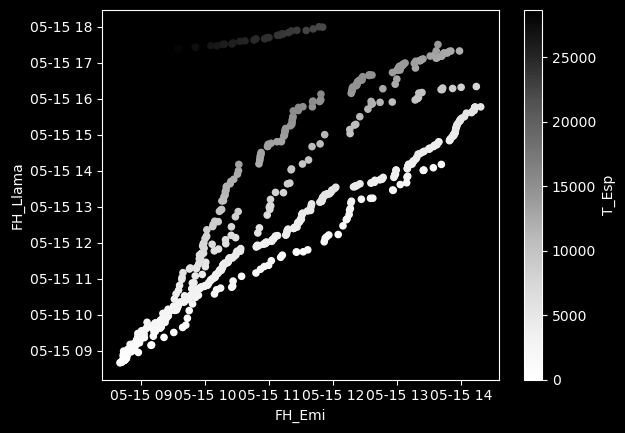

In [19]:
import pandas as pd

IdOficina : int = 2 # Se le pasa arriba, pero no creo que lo usaba para nada

def formatea_tabla_simulador(df : pd.DataFrame) -> pd.DataFrame:
    
    df['IdOficina'] = IdOficina
    df['FH_AteIni'] = df['FH_Emi'].astype('datetime64[s]') + pd.to_timedelta( df['espera'], unit='seconds' )
    df['FH_Llama']  = df['FH_AteIni']  # BUG: posiblemente no necesario
    df['FH_AteFin'] = df['FH_AteIni'] + pd.to_timedelta( df['T_Ate'], unit='seconds' )

    df = df.rename(columns={'espera' : 'T_Esp'})

    return df[["IdOficina","IdSerie","IdEsc","FH_Emi","FH_Llama","FH_AteIni","FH_AteFin","T_Esp","T_Ate"]]


# IdOficina	IdSerie	IdEsc	FH_Emi	FH_Llama	FH_AteIni	FH_AteFin	T_Esp	T_Ate
formatea_tabla_simulador(registros_atenciones).astype({"IdSerie":"category"}).plot.scatter(x='FH_Emi', y='FH_Llama', c='T_Esp')

# Workforce manager

In [4]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import random
import optuna
from src.datos_utils import DatasetTTP, obtener_skills
from src.optuna_utils import non_empty_subsets
import itertools
import numpy as np
from src.optuna_utils import plan_unico
from dev.atributos_de_series import atributos_x_serie
import optuna
import numpy as np
import time
from src.optuna_utils import (
    sla_x_serie, 
    extract_skills_length, 
    non_empty_subsets
    )
from   src.utils_Escritoriosv05_Simv05 import (
                                            get_permutations_array,
                                           plan_unico,
                                           generar_planificacion,
                                           extract_min_value_keys,
                                            DatasetTTP,
                                            get_time_intervals,
                                            partition_dataframe_by_time_intervals)
from dev.Escritoriosv05_Simv05 import simv05
from dev.atributos_de_series import atributos_x_serie
import math

def objective(trial, 
    un_dia : pd.DataFrame,  # IdOficina  IdSerie  IdEsc, FH_Emi, FH_Llama  -- Deberia llamarse 'un_tramo'
    subsets: list, # [(5,), (10,), (11,), (12,), (14,), (17,), (5, 10), (5, 11), (5, 12), (5, 14), (5, 17), (10, 11),  <...> 14, 17), (5, 10, 12, 14, 17), (5, 11, 12, 14, 17), (10, 11, 12, 14, 17), (5, 10, 11, 12, 14, 17)]
    hora_cierre:str,
    modos_atenciones : list = ["Alternancia", "FIFO", "Rebalse"],
    pesos_x_serie: dict = None,
    optimizar: str = "SLA",
    minimo_escritorios: int = 2,
    maximo_escritorios: int = 5,
    niveles_servicio_x_serie = None,
    series                   : list = None
    ):    
    all_permutations = list(itertools.permutations([r+1 for r in range(len(series))]))
    try:
        
        n_escritorios = trial.suggest_int(
             f'prioridades', minimo_escritorios, maximo_escritorios )
        print(f"---------------------n_escritorios {n_escritorios}")
        #bool_vector              = [trial.suggest_categorical(f'escritorio_{i}', [True, False]) for i in range(n_escritorios)]
        #Restricción de minimo de escritorios
        #assert sum(bool_vector) >= minimo_escritorios, f"No cumple con minimo_escritorios: {minimo_escritorios}."
        
        str_dict                 = {i: trial.suggest_categorical(f'{i}',         modos_atenciones) for i in range(n_escritorios)} 
        subset_idx               = {i: trial.suggest_int(f'ids_{i}', 0, len(subsets) - 1) for i in range(n_escritorios)}   
        #prioridades              =  prioridad_x_serie(niveles_servicio_x_serie, 2, 1) 
        planificacion_optuna            =  {} # Arma una planificacion con espacios parametricos. 
        inicio                   =  str(un_dia.FH_Emi.min().time())#'08:33:00'
        termino                  =  str(un_dia.FH_Emi.max().time())#'14:33:00'        
        #skills_len = len(list(subsets[subset_idx[key]]))        
        for key in str_dict.keys():
            #if bool_vector[key]:
                #skills                    = list(subsets[subset_idx[key]])
                #permutaciones_prioridades = get_permutations_array(list(subsets[subset_idx[key]]).__len__())
                inner_dict = {
                    'inicio': inicio,
                    'termino': termino,
                    'propiedades': {
                        'skills': list(subsets[subset_idx[key]]),# list(subsets[subset_idx[key]]), # Set -> Lista, para el subset 'subset_idx', para el escritorio 'key'
                        'configuracion_atencion': str_dict[key], # 
                        'prioridades': 
                                    {s: r for s,r in zip(series, all_permutations
                                    [trial.suggest_int('idx', 0, len(all_permutations) - 1)])}
                                  ,
                        'pasos': {i: trial.suggest_int(f'pasos_{i}', 1, 4) for i in list(subsets[subset_idx[key]])},
                    }
                }
                planificacion_optuna[str(key)] = [inner_dict] # NOTE: Es una lista why -- Config por trial por tramo del escritorio 
                
                
                

                
        planificacion = {un_escritorio[0]:
                [
                    {
                    'inicio': un_escritorio[1][0]['inicio'],
                'termino':un_escritorio[1][0]['termino'],
                'propiedades':{
                    'skills': un_escritorio[1][0]['propiedades']['skills'],
                'configuracion_atencion': un_escritorio[1][0]['propiedades']['configuracion_atencion'],
                'porcentaje_actividad'  : np.random.randint(85, 90)/100,                
                'atributos_series':
                    atributos_x_serie(ids_series=un_escritorio[1][0]['propiedades']['skills'], 
                                                sla_porcen_user=[niveles_servicio_x_serie[s][0] for s in un_escritorio[1][0]['propiedades']['skills']]
            , 
                                                sla_corte_user=[niveles_servicio_x_serie[s][1] for s in un_escritorio[1][0]['propiedades']['skills']]
            , 
                                                pasos_user=list(un_escritorio[1][0]['propiedades']['pasos'].values()), 
                                                prioridades_user=list(un_escritorio[1][0]['propiedades']['prioridades'].values())),
                },}]
                for un_escritorio in planificacion_optuna.items()}

                        
        trial.set_user_attr('planificacion', planificacion) # This' actually cool 
        
        
        nested_list =  [e[0]['propiedades']['skills'] for k, e in  planificacion.items()]
        assert set([item for sublist in nested_list for item in sublist]) == set(series), "no todas las series incluidas"
        
        registros_atenciones, _      = simv05(un_dia, hora_cierre, planificacion)   
        registros_atenciones['IdSerie'] = registros_atenciones['IdSerie'].astype(int) 
        registros_x_serie               = [registros_atenciones[registros_atenciones.IdSerie==s] for s in series]
        pocentajes_SLA        = [int(100*v[0])for k,v in niveles_servicio_x_serie.items()]
        mins_de_corte_SLA     = [int(v[1])for k,v in niveles_servicio_x_serie.items()]        
        df_pairs              = [(sla_x_serie(r_x_s, '1H', corte = corte), s) 
                                 for r_x_s, s, corte in zip(registros_x_serie, series, mins_de_corte_SLA)]
        porcentajes_reales    = {f"serie: {serie}": np.mean(esperas.espera) for ((demandas, esperas), serie) in df_pairs} 
        
        
        assert not any(math.isnan(x) for x in [v for k, v in porcentajes_reales.items()]), "porcentajes_reales contains at least one nan"

        
        print(f"------------porcentajes_reales {[v for k, v in porcentajes_reales.items()]}")
        print(f"----------------pocentajes_SLA :{pocentajes_SLA}")
        #print(f"sla_real: {sla_real} - sla_teorico {sla_teorico}")
        dif_cuadratica        = {k:((sla_real-sla_teorico)**2 if sla_real < sla_teorico else abs((sla_real-sla_teorico)) ) 
                                 for ((k,sla_real),sla_teorico) in zip(porcentajes_reales.items(),pocentajes_SLA)}
        #Objetivos:    
        #La mayor prioridad es el entero más chico    
        maximizar_SLAs        = tuple(np.array(tuple(pesos_x_serie.values()))*np.array(tuple(dif_cuadratica.values())))#Ponderado por prioridad
        minimizar_escritorios = (10*n_escritorios**2,)
        minimizar_skills      = (extract_skills_length(planificacion)**2,)
        
        
        
        assert not any(math.isnan(x) for x in maximizar_SLAs), "al menos un SLA NaN"
        
        if optimizar == "SLA":
            
            print(f"--OBJ-- maximizar_SLAs           {maximizar_SLAs}")
            return  maximizar_SLAs
        
        elif optimizar == "SLA + escritorios":
            
            print(f"maximizar_SLAs y minimizar_escritorios { maximizar_SLAs + minimizar_escritorios}")
            return  maximizar_SLAs + minimizar_escritorios
        
        elif optimizar == "SLA + skills":
            
            print(f"maximizar_SLAs y minimizar_skills {maximizar_SLAs + minimizar_skills}")
            return  maximizar_SLAs + minimizar_skills
        
        elif optimizar == "SLA + escritorios + skills":
            
            print(f"SLA + escritorios + skills {maximizar_SLAs + minimizar_escritorios + minimizar_skills}")
            return  maximizar_SLAs + minimizar_escritorios + minimizar_skills        
    except Exception as e:
        print(f"An exception occurred: {e}")
        raise optuna.TrialPruned()
    
dataset                                 = DatasetTTP.desde_csv_atenciones("data/fonasa_monjitas.csv.gz") # IdOficina=2)
un_dia                                  = dataset.un_dia("2023-05-15").sort_values(by='FH_Emi', inplace=False)
skills       = obtener_skills(un_dia)
series       = sorted(list({val for sublist in skills.values() for val in sublist}))
atributos_series = atributos_x_serie(ids_series=series, 
                                    sla_porcen_user=None, 
                                    sla_corte_user=None, 
                                    pasos_user=None, 
                                    prioridades_user=None)
niveles_servicio_x_serie = {atr_dict['serie']:
                            (atr_dict['sla_porcen']/100, atr_dict['sla_corte']) 
                            for atr_dict in atributos_series}

intervals  = get_time_intervals(un_dia, n = 4, porcentaje_actividad = 1) # Una funcion que recibe un dia, un intervalo, y un porcentaje de actividad para todos los intervalos
partitions = partition_dataframe_by_time_intervals(un_dia, intervals) # TODO: implementar como un static del simulador? 
storage = optuna.storages.get_storage("sqlite:///alejandro_objs_v05.db")
n_trials     = 5
optimizar    ="SLA" #"SLA + escritorios + skills" #"SLA" | "SLA + escritorios" | "SLA + skills" | "SLA + escritorios + skills"
n_objs       = int(
                        len(series)
                        if optimizar == "SLA"
                        else len(series) + 1
                        if optimizar in {"SLA + escritorios", "SLA + skills"}
                        else len(series) + 2
                        if optimizar == "SLA + escritorios + skills"
                        else None
                        )
pesos_x_serie = {s: random.randint(1,len(series)) for s in series}
for idx, (part, inters) in enumerate(zip(partitions,intervals)):
    print(inters)
    #print(idx, part, inters[1])
    
    study_name = f"tramo_{idx}"
    study = optuna.multi_objective.create_study(directions= n_objs*['minimize'],
                                                study_name=study_name,
                                                storage=storage, load_if_exists=True)
    # TODO: sacar fuera
    # Optimize with a timeout (in seconds)
    
    subsets      = non_empty_subsets(sorted(list({val for sublist in obtener_skills(part).values() for val in sublist})))

    
    study.optimize(lambda trial: objective(trial,
                                           optimizar                = optimizar,
                                           un_dia                   = part,
                                           subsets                  = subsets,
                                           hora_cierre              =  inters[1],
                                           pesos_x_serie            = pesos_x_serie,
                                           minimo_escritorios       = 10,
                                           maximo_escritorios       = 13,
                                           niveles_servicio_x_serie = niveles_servicio_x_serie,
                                           series                   = sorted(list({val for sublist in obtener_skills(part).values() for val in sublist}))   
                                           ),
                   n_trials  = n_trials, #int(1e4),  # Make sure this is an integer
                   timeout   = 2*3600,   #  hours
                   )  # 

[I 2023-11-14 03:26:53,067] Using an existing study with name 'tramo_0' instead of creating a new one.


('08:40:11', '10:07:44')
---------------------n_escritorios 12


[I 2023-11-14 03:26:54,527] Trial 11 finished with values: (162.0,) with parameters: {'prioridades': 12, '0': 'Rebalse', '1': 'Rebalse', '2': 'Alternancia', '3': 'Rebalse', '4': 'Rebalse', '5': 'Alternancia', '6': 'Rebalse', '7': 'Alternancia', '8': 'Alternancia', '9': 'Alternancia', '10': 'Alternancia', '11': 'FIFO', 'ids_0': 35, 'ids_1': 16, 'ids_2': 20, 'ids_3': 17, 'ids_4': 38, 'ids_5': 29, 'ids_6': 51, 'ids_7': 56, 'ids_8': 20, 'ids_9': 26, 'ids_10': 0, 'ids_11': 53, 'idx': 429, 'pasos_10': 1, 'pasos_12': 4, 'pasos_17': 1, 'pasos_11': 4, 'pasos_14': 1, 'pasos_5': 4}.


------------porcentajes_reales [100.0, 31.25, 100.0, 100.0, 75.0, 100.0]
----------------pocentajes_SLA :[73, 80, 73, 83, 82, 75]
--OBJ-- maximizar_SLAs           (162.0, 14259.375, 135.0, 85.0, 49.0, 150.0)
---------------------n_escritorios 10


[I 2023-11-14 03:26:55,629] Trial 12 finished with values: (162.0,) with parameters: {'prioridades': 10, '0': 'FIFO', '1': 'Alternancia', '2': 'Rebalse', '3': 'Rebalse', '4': 'FIFO', '5': 'Rebalse', '6': 'FIFO', '7': 'Rebalse', '8': 'Alternancia', '9': 'Alternancia', 'ids_0': 47, 'ids_1': 40, 'ids_2': 25, 'ids_3': 25, 'ids_4': 54, 'ids_5': 58, 'ids_6': 61, 'ids_7': 60, 'ids_8': 46, 'ids_9': 8, 'idx': 338, 'pasos_5': 2, 'pasos_11': 4, 'pasos_12': 1, 'pasos_14': 2, 'pasos_17': 3, 'pasos_10': 3}.


------------porcentajes_reales [100.0, 9.090909090909092, 100.0, 100.0, 61.111111111111114, 100.0]
----------------pocentajes_SLA :[73, 80, 73, 83, 82, 75]
--OBJ-- maximizar_SLAs           (162.0, 30168.595041322315, 135.0, 85.0, 436.34567901234556, 150.0)
---------------------n_escritorios 13


[I 2023-11-14 03:26:57,126] Trial 13 finished with values: (162.0,) with parameters: {'prioridades': 13, '0': 'FIFO', '1': 'Alternancia', '2': 'Rebalse', '3': 'Alternancia', '4': 'FIFO', '5': 'FIFO', '6': 'Alternancia', '7': 'Alternancia', '8': 'Alternancia', '9': 'Alternancia', '10': 'Rebalse', '11': 'FIFO', '12': 'FIFO', 'ids_0': 50, 'ids_1': 29, 'ids_2': 20, 'ids_3': 36, 'ids_4': 51, 'ids_5': 13, 'ids_6': 50, 'ids_7': 48, 'ids_8': 47, 'ids_9': 27, 'ids_10': 55, 'ids_11': 13, 'ids_12': 45, 'idx': 600, 'pasos_5': 3, 'pasos_12': 2, 'pasos_14': 4, 'pasos_17': 3, 'pasos_10': 4, 'pasos_11': 1}.


------------porcentajes_reales [100.0, 24.137931034482758, 100.0, 100.0, 77.27272727272727, 100.0]
----------------pocentajes_SLA :[73, 80, 73, 83, 82, 75]
--OBJ-- maximizar_SLAs           (162.0, 18723.424494649225, 135.0, 85.0, 22.34710743801659, 150.0)
---------------------n_escritorios 10


[I 2023-11-14 03:26:58,404] Trial 14 finished with values: (162.0,) with parameters: {'prioridades': 10, '0': 'Alternancia', '1': 'Alternancia', '2': 'Alternancia', '3': 'Alternancia', '4': 'Rebalse', '5': 'FIFO', '6': 'Alternancia', '7': 'Rebalse', '8': 'Alternancia', '9': 'Rebalse', 'ids_0': 59, 'ids_1': 26, 'ids_2': 30, 'ids_3': 50, 'ids_4': 38, 'ids_5': 11, 'ids_6': 49, 'ids_7': 21, 'ids_8': 53, 'ids_9': 8, 'idx': 503, 'pasos_5': 3, 'pasos_10': 2, 'pasos_12': 2, 'pasos_14': 2, 'pasos_17': 4, 'pasos_11': 1}.


------------porcentajes_reales [100.0, 40.0, 100.0, 100.0, 47.05882352941176, 100.0]
----------------pocentajes_SLA :[73, 80, 73, 83, 82, 75]
--OBJ-- maximizar_SLAs           (162.0, 9600.0, 135.0, 85.0, 1220.885813148789, 150.0)
---------------------n_escritorios 12


[I 2023-11-14 03:26:59,773] Trial 15 finished with values: (162.0,) with parameters: {'prioridades': 12, '0': 'Alternancia', '1': 'FIFO', '2': 'Rebalse', '3': 'Alternancia', '4': 'Alternancia', '5': 'Alternancia', '6': 'FIFO', '7': 'FIFO', '8': 'Rebalse', '9': 'Alternancia', '10': 'Rebalse', '11': 'FIFO', 'ids_0': 14, 'ids_1': 33, 'ids_2': 51, 'ids_3': 55, 'ids_4': 41, 'ids_5': 4, 'ids_6': 16, 'ids_7': 56, 'ids_8': 28, 'ids_9': 59, 'ids_10': 0, 'ids_11': 5, 'idx': 374, 'pasos_10': 2, 'pasos_17': 1, 'pasos_11': 2, 'pasos_12': 3, 'pasos_14': 3, 'pasos_5': 2}.
[I 2023-11-14 03:26:59,827] Using an existing study with name 'tramo_1' instead of creating a new one.


------------porcentajes_reales [100.0, 25.0, 30.0, 100.0, 25.0, 100.0]
----------------pocentajes_SLA :[73, 80, 73, 83, 82, 75]
--OBJ-- maximizar_SLAs           (162.0, 18150.0, 9245.0, 85.0, 3249.0, 150.0)
('10:07:44', '11:35:17')
---------------------n_escritorios 13


[I 2023-11-14 03:27:01,436] Trial 10 finished with values: (1014.0,) with parameters: {'prioridades': 13, '0': 'FIFO', '1': 'FIFO', '2': 'Alternancia', '3': 'Alternancia', '4': 'Rebalse', '5': 'FIFO', '6': 'Alternancia', '7': 'Alternancia', '8': 'Alternancia', '9': 'FIFO', '10': 'Alternancia', '11': 'Alternancia', '12': 'Alternancia', 'ids_0': 52, 'ids_1': 3, 'ids_2': 13, 'ids_3': 2, 'ids_4': 61, 'ids_5': 30, 'ids_6': 41, 'ids_7': 10, 'ids_8': 21, 'ids_9': 13, 'ids_10': 58, 'ids_11': 51, 'ids_12': 59, 'idx': 390, 'pasos_10': 2, 'pasos_11': 4, 'pasos_12': 2, 'pasos_17': 1, 'pasos_14': 4, 'pasos_5': 4}.


------------porcentajes_reales [60.0, 39.39393939393939, 70.0, 100.0, 96.55172413793103, 33.33333333333333]
----------------pocentajes_SLA :[73, 80, 73, 83, 82, 75]
--OBJ-- maximizar_SLAs           (1014.0, 9893.112947658405, 45.0, 85.0, 14.551724137931032, 10416.66666666667)
---------------------n_escritorios 11


[I 2023-11-14 03:27:02,673] Trial 11 finished with values: (162.0,) with parameters: {'prioridades': 11, '0': 'Alternancia', '1': 'Alternancia', '2': 'FIFO', '3': 'FIFO', '4': 'Rebalse', '5': 'Alternancia', '6': 'FIFO', '7': 'FIFO', '8': 'Rebalse', '9': 'Rebalse', '10': 'Alternancia', 'ids_0': 48, 'ids_1': 52, 'ids_2': 55, 'ids_3': 4, 'ids_4': 32, 'ids_5': 60, 'ids_6': 34, 'ids_7': 9, 'ids_8': 31, 'ids_9': 29, 'ids_10': 40, 'idx': 296, 'pasos_5': 2, 'pasos_11': 3, 'pasos_12': 4, 'pasos_17': 1, 'pasos_10': 4, 'pasos_14': 2}.


------------porcentajes_reales [100.0, 31.57894736842105, 20.0, 100.0, 57.692307692307686, 60.0]
----------------pocentajes_SLA :[73, 80, 73, 83, 82, 75]
--OBJ-- maximizar_SLAs           (162.0, 14067.59002770083, 14045.0, 85.0, 590.8639053254441, 1350.0)
---------------------n_escritorios 10


[I 2023-11-14 03:27:03,873] Trial 12 finished with values: (162.0,) with parameters: {'prioridades': 10, '0': 'Alternancia', '1': 'FIFO', '2': 'Alternancia', '3': 'FIFO', '4': 'FIFO', '5': 'Rebalse', '6': 'Rebalse', '7': 'Alternancia', '8': 'Alternancia', '9': 'FIFO', 'ids_0': 47, 'ids_1': 48, 'ids_2': 46, 'ids_3': 8, 'ids_4': 62, 'ids_5': 61, 'ids_6': 61, 'ids_7': 23, 'ids_8': 6, 'ids_9': 20, 'idx': 91, 'pasos_5': 2, 'pasos_11': 3, 'pasos_12': 1, 'pasos_14': 4, 'pasos_17': 4, 'pasos_10': 4}.


------------porcentajes_reales [100.0, 42.42424242424242, 0.0, 100.0, 41.17647058823529, 40.0]
----------------pocentajes_SLA :[73, 80, 73, 83, 82, 75]
--OBJ-- maximizar_SLAs           (162.0, 8471.625344352618, 26645.0, 85.0, 1666.5605536332184, 7350.0)
---------------------n_escritorios 10


[I 2023-11-14 03:27:05,035] Trial 13 finished with values: (7561.5,) with parameters: {'prioridades': 10, '0': 'FIFO', '1': 'FIFO', '2': 'FIFO', '3': 'FIFO', '4': 'Alternancia', '5': 'Rebalse', '6': 'Alternancia', '7': 'FIFO', '8': 'Alternancia', '9': 'Alternancia', 'ids_0': 60, 'ids_1': 12, 'ids_2': 2, 'ids_3': 50, 'ids_4': 18, 'ids_5': 42, 'ids_6': 2, 'ids_7': 40, 'ids_8': 35, 'ids_9': 16, 'idx': 639, 'pasos_5': 4, 'pasos_11': 4, 'pasos_12': 2, 'pasos_14': 1, 'pasos_17': 2, 'pasos_10': 2}.


------------porcentajes_reales [37.5, 28.57142857142857, 100.0, 50.0, 45.83333333333333, 12.5]
----------------pocentajes_SLA :[73, 80, 73, 83, 82, 75]
--OBJ-- maximizar_SLAs           (7561.5, 15869.387755102041, 135.0, 5445.0, 1308.027777777778, 23437.5)
---------------------n_escritorios 13


[I 2023-11-14 03:27:06,365] Trial 14 finished with values: (162.0,) with parameters: {'prioridades': 13, '0': 'Rebalse', '1': 'Rebalse', '2': 'Alternancia', '3': 'FIFO', '4': 'FIFO', '5': 'Rebalse', '6': 'Alternancia', '7': 'Alternancia', '8': 'Alternancia', '9': 'FIFO', '10': 'FIFO', '11': 'FIFO', '12': 'FIFO', 'ids_0': 24, 'ids_1': 7, 'ids_2': 39, 'ids_3': 12, 'ids_4': 17, 'ids_5': 31, 'ids_6': 5, 'ids_7': 7, 'ids_8': 2, 'ids_9': 48, 'ids_10': 8, 'ids_11': 30, 'ids_12': 16, 'idx': 383, 'pasos_5': 4, 'pasos_10': 2, 'pasos_17': 2, 'pasos_11': 4, 'pasos_14': 2, 'pasos_12': 2}.
[I 2023-11-14 03:27:06,417] Using an existing study with name 'tramo_2' instead of creating a new one.


------------porcentajes_reales [100.0, 35.0, 100.0, 83.33333333333333, 48.275862068965516, 62.49999999999999]
----------------pocentajes_SLA :[73, 80, 73, 83, 82, 75]
--OBJ-- maximizar_SLAs           (162.0, 12150.0, 135.0, 1.666666666666643, 1137.317479191439, 937.500000000001)
('11:35:17', '13:02:50')
---------------------n_escritorios 11


[I 2023-11-14 03:27:07,605] Trial 10 finished with values: (25.636363636363598,) with parameters: {'prioridades': 11, '0': 'FIFO', '1': 'Alternancia', '2': 'Rebalse', '3': 'FIFO', '4': 'Alternancia', '5': 'FIFO', '6': 'FIFO', '7': 'Alternancia', '8': 'FIFO', '9': 'Alternancia', '10': 'Alternancia', 'ids_0': 17, 'ids_1': 57, 'ids_2': 59, 'ids_3': 19, 'ids_4': 54, 'ids_5': 40, 'ids_6': 3, 'ids_7': 51, 'ids_8': 31, 'ids_9': 49, 'ids_10': 40, 'idx': 14, 'pasos_11': 1, 'pasos_17': 2, 'pasos_5': 2, 'pasos_10': 4, 'pasos_12': 2, 'pasos_14': 2}.


------------porcentajes_reales [77.27272727272727, 22.916666666666664, 83.33333333333333, 100.0, 35.714285714285715, 66.66666666666666]
----------------pocentajes_SLA :[73, 80, 73, 83, 82, 75]
--OBJ-- maximizar_SLAs           (25.636363636363598, 19551.041666666668, 51.66666666666664, 85.0, 2142.3673469387754, 416.6666666666676)
---------------------n_escritorios 12


[I 2023-11-14 03:27:08,849] Trial 11 finished with values: (12.0,) with parameters: {'prioridades': 12, '0': 'Rebalse', '1': 'Alternancia', '2': 'Rebalse', '3': 'Alternancia', '4': 'Alternancia', '5': 'Rebalse', '6': 'Alternancia', '7': 'Rebalse', '8': 'FIFO', '9': 'Rebalse', '10': 'Rebalse', '11': 'FIFO', 'ids_0': 25, 'ids_1': 21, 'ids_2': 1, 'ids_3': 53, 'ids_4': 19, 'ids_5': 49, 'ids_6': 10, 'ids_7': 23, 'ids_8': 17, 'ids_9': 20, 'ids_10': 9, 'ids_11': 44, 'idx': 404, 'pasos_5': 4, 'pasos_11': 1, 'pasos_12': 4, 'pasos_10': 3, 'pasos_14': 3, 'pasos_17': 4}.


------------porcentajes_reales [75.0, 27.083333333333332, 100.0, 75.0, 62.857142857142854, 100.0]
----------------pocentajes_SLA :[73, 80, 73, 83, 82, 75]
--OBJ-- maximizar_SLAs           (12.0, 16801.04166666667, 135.0, 320.0, 366.44897959183686, 150.0)
---------------------n_escritorios 12


[I 2023-11-14 03:27:10,195] Trial 12 finished with values: (76.28571428571433,) with parameters: {'prioridades': 12, '0': 'Alternancia', '1': 'FIFO', '2': 'Rebalse', '3': 'Rebalse', '4': 'Alternancia', '5': 'Alternancia', '6': 'Rebalse', '7': 'Alternancia', '8': 'Rebalse', '9': 'Rebalse', '10': 'Alternancia', '11': 'Rebalse', 'ids_0': 59, 'ids_1': 26, 'ids_2': 50, 'ids_3': 50, 'ids_4': 57, 'ids_5': 54, 'ids_6': 39, 'ids_7': 27, 'ids_8': 47, 'ids_9': 52, 'ids_10': 40, 'ids_11': 26, 'idx': 568, 'pasos_5': 1, 'pasos_10': 1, 'pasos_12': 3, 'pasos_14': 4, 'pasos_17': 2, 'pasos_11': 1}.


------------porcentajes_reales [85.71428571428572, 58.333333333333336, 100.0, 100.0, 76.3157894736842, 100.0]
----------------pocentajes_SLA :[73, 80, 73, 83, 82, 75]
--OBJ-- maximizar_SLAs           (76.28571428571433, 2816.666666666666, 135.0, 85.0, 32.31024930747928, 150.0)
---------------------n_escritorios 10


[I 2023-11-14 03:27:11,379] Trial 13 finished with values: (12.0,) with parameters: {'prioridades': 10, '0': 'FIFO', '1': 'Alternancia', '2': 'Alternancia', '3': 'FIFO', '4': 'FIFO', '5': 'Rebalse', '6': 'Alternancia', '7': 'Alternancia', '8': 'Rebalse', '9': 'Rebalse', 'ids_0': 33, 'ids_1': 12, 'ids_2': 8, 'ids_3': 1, 'ids_4': 40, 'ids_5': 17, 'ids_6': 40, 'ids_7': 55, 'ids_8': 50, 'ids_9': 57, 'idx': 321, 'pasos_10': 2, 'pasos_11': 2, 'pasos_17': 3, 'pasos_12': 4, 'pasos_5': 2, 'pasos_14': 1}.


------------porcentajes_reales [75.0, 29.166666666666668, 100.0, 100.0, 79.16666666666667, 75.0]
----------------pocentajes_SLA :[73, 80, 73, 83, 82, 75]
--OBJ-- maximizar_SLAs           (12.0, 15504.166666666664, 135.0, 85.0, 8.02777777777775, 0.0)
---------------------n_escritorios 11


[I 2023-11-14 03:27:12,521] Trial 14 finished with values: (162.0,) with parameters: {'prioridades': 11, '0': 'Rebalse', '1': 'Rebalse', '2': 'FIFO', '3': 'Alternancia', '4': 'Rebalse', '5': 'FIFO', '6': 'Rebalse', '7': 'Rebalse', '8': 'Rebalse', '9': 'Alternancia', '10': 'FIFO', 'ids_0': 20, 'ids_1': 17, 'ids_2': 7, 'ids_3': 45, 'ids_4': 42, 'ids_5': 49, 'ids_6': 34, 'ids_7': 0, 'ids_8': 30, 'ids_9': 57, 'ids_10': 12, 'idx': 348, 'pasos_14': 1, 'pasos_17': 4, 'pasos_11': 3, 'pasos_5': 2, 'pasos_10': 3, 'pasos_12': 1}.
[I 2023-11-14 03:27:12,575] Using an existing study with name 'tramo_3' instead of creating a new one.


------------porcentajes_reales [100.0, 43.47826086956522, 100.0, 83.33333333333333, 71.42857142857143, 80.0]
----------------pocentajes_SLA :[73, 80, 73, 83, 82, 75]
--OBJ-- maximizar_SLAs           (162.0, 8003.024574669186, 135.0, 1.666666666666643, 111.75510204081628, 30.0)
('13:02:50', '14:30:23')
---------------------n_escritorios 11


[I 2023-11-14 03:27:14,041] Trial 10 finished with values: (162.0,) with parameters: {'prioridades': 11, '0': 'Alternancia', '1': 'Alternancia', '2': 'Rebalse', '3': 'Alternancia', '4': 'Rebalse', '5': 'Rebalse', '6': 'Alternancia', '7': 'Alternancia', '8': 'Alternancia', '9': 'FIFO', '10': 'Alternancia', 'ids_0': 13, 'ids_1': 14, 'ids_2': 47, 'ids_3': 51, 'ids_4': 42, 'ids_5': 10, 'ids_6': 47, 'ids_7': 54, 'ids_8': 32, 'ids_9': 0, 'ids_10': 26, 'idx': 169, 'pasos_10': 1, 'pasos_14': 3, 'pasos_17': 1, 'pasos_5': 4, 'pasos_11': 2, 'pasos_12': 4}.


------------porcentajes_reales [100.0, 26.08695652173913, 92.85714285714286, 100.0, 100.0, 21.428571428571427]
----------------pocentajes_SLA :[73, 80, 73, 83, 82, 75]
--OBJ-- maximizar_SLAs           (162.0, 17439.697542533082, 99.2857142857143, 85.0, 18.0, 17219.38775510204)
---------------------n_escritorios 12


[I 2023-11-14 03:27:15,157] Trial 11 finished with values: (1825.8518518518517,) with parameters: {'prioridades': 12, '0': 'FIFO', '1': 'FIFO', '2': 'FIFO', '3': 'Rebalse', '4': 'FIFO', '5': 'FIFO', '6': 'Alternancia', '7': 'Rebalse', '8': 'Rebalse', '9': 'Alternancia', '10': 'FIFO', '11': 'Rebalse', 'ids_0': 60, 'ids_1': 32, 'ids_2': 54, 'ids_3': 24, 'ids_4': 51, 'ids_5': 53, 'ids_6': 31, 'ids_7': 48, 'ids_8': 36, 'ids_9': 47, 'ids_10': 37, 'ids_11': 34, 'idx': 597, 'pasos_5': 4, 'pasos_11': 1, 'pasos_12': 3, 'pasos_14': 1, 'pasos_17': 3, 'pasos_10': 3}.


------------porcentajes_reales [55.55555555555556, 41.02564102564102, 42.857142857142854, 100.0, 76.0, 100.0]
----------------pocentajes_SLA :[73, 80, 73, 83, 82, 75]
--OBJ-- maximizar_SLAs           (1825.8518518518517, 9114.003944773176, 4542.959183673471, 85.0, 36.0, 150.0)
---------------------n_escritorios 13


[I 2023-11-14 03:27:16,739] Trial 12 finished with values: (162.0,) with parameters: {'prioridades': 13, '0': 'Rebalse', '1': 'Alternancia', '2': 'Alternancia', '3': 'Alternancia', '4': 'Alternancia', '5': 'Alternancia', '6': 'Rebalse', '7': 'Alternancia', '8': 'Alternancia', '9': 'Rebalse', '10': 'Rebalse', '11': 'FIFO', '12': 'FIFO', 'ids_0': 54, 'ids_1': 42, 'ids_2': 62, 'ids_3': 59, 'ids_4': 32, 'ids_5': 9, 'ids_6': 58, 'ids_7': 50, 'ids_8': 7, 'ids_9': 31, 'ids_10': 62, 'ids_11': 36, 'ids_12': 8, 'idx': 592, 'pasos_10': 3, 'pasos_12': 1, 'pasos_14': 1, 'pasos_17': 1, 'pasos_5': 4, 'pasos_11': 1}.


------------porcentajes_reales [100.0, 32.5, 100.0, 100.0, 100.0, 100.0]
----------------pocentajes_SLA :[73, 80, 73, 83, 82, 75]
--OBJ-- maximizar_SLAs           (162.0, 13537.5, 135.0, 85.0, 18.0, 150.0)
---------------------n_escritorios 13


[I 2023-11-14 03:27:18,111] Trial 13 finished with values: (162.0,) with parameters: {'prioridades': 13, '0': 'Alternancia', '1': 'FIFO', '2': 'FIFO', '3': 'FIFO', '4': 'FIFO', '5': 'Rebalse', '6': 'FIFO', '7': 'FIFO', '8': 'FIFO', '9': 'Alternancia', '10': 'Alternancia', '11': 'Alternancia', '12': 'FIFO', 'ids_0': 22, 'ids_1': 39, 'ids_2': 4, 'ids_3': 46, 'ids_4': 6, 'ids_5': 34, 'ids_6': 17, 'ids_7': 5, 'ids_8': 38, 'ids_9': 50, 'ids_10': 46, 'ids_11': 46, 'ids_12': 61, 'idx': 176, 'pasos_5': 1, 'pasos_10': 2, 'pasos_12': 2, 'pasos_11': 4, 'pasos_14': 3, 'pasos_17': 4}.


------------porcentajes_reales [100.0, 29.72972972972973, 71.42857142857143, 95.0, 96.15384615384616, 59.52380952380952]
----------------pocentajes_SLA :[73, 80, 73, 83, 82, 75]
--OBJ-- maximizar_SLAs           (162.0, 15162.600438276115, 12.346938775510171, 60.0, 14.15384615384616, 1437.074829931974)
---------------------n_escritorios 10


[I 2023-11-14 03:27:19,323] Trial 14 finished with values: (4892.518518518519,) with parameters: {'prioridades': 10, '0': 'FIFO', '1': 'Rebalse', '2': 'Rebalse', '3': 'Alternancia', '4': 'Alternancia', '5': 'Alternancia', '6': 'Rebalse', '7': 'Alternancia', '8': 'Rebalse', '9': 'Alternancia', 'ids_0': 22, 'ids_1': 48, 'ids_2': 49, 'ids_3': 60, 'ids_4': 57, 'ids_5': 1, 'ids_6': 44, 'ids_7': 37, 'ids_8': 21, 'ids_9': 58, 'idx': 363, 'pasos_5': 4, 'pasos_10': 1, 'pasos_12': 1, 'pasos_11': 2, 'pasos_17': 3, 'pasos_14': 4}.


------------porcentajes_reales [44.44444444444444, 42.10526315789473, 100.0, 100.0, 52.94117647058824, 50.0]
----------------pocentajes_SLA :[73, 80, 73, 83, 82, 75]
--OBJ-- maximizar_SLAs           (4892.518518518519, 8616.066481994461, 135.0, 85.0, 844.4152249134946, 3750.0)


## Extracción de la planificación óptima

In [5]:
recomendaciones_db   = optuna.storages.get_storage("sqlite:///alejandro_objs_v05.db") # Objetivos de 6-salidas
resumenes            = optuna.study.get_all_study_summaries(recomendaciones_db)
nombres              = [s.study_name for s in resumenes if "tramo_" in s.study_name]

scores_studios = {}
for un_nombre in nombres:
    un_estudio            = optuna.multi_objective.load_study(study_name=un_nombre, storage=recomendaciones_db)
    trials_de_un_estudio  = un_estudio.get_trials(deepcopy=False) #or pareto trials??
    scores_studios        = scores_studios | {f"{un_nombre}":
        { trial.number: np.mean([x for x in trial.values if x is not None]) 
                for
                    trial in trials_de_un_estudio if trial.state == optuna.trial.TrialState.COMPLETE}
                    } 
    
trials_optimos          = extract_min_value_keys(scores_studios) # Para cada tramo, extrae el maximo, 
planificaciones_optimas = {}   
for k,v in trials_optimos.items():
    un_estudio               = optuna.multi_objective.load_study(study_name=k, storage=recomendaciones_db)
    trials_de_un_estudio     = un_estudio.get_trials(deepcopy=False)
    planificaciones_optimas  = planificaciones_optimas | {f"{k}":
        trial.user_attrs.get('planificacion')#calcular_optimo(trial.values)
                for
                    trial in trials_de_un_estudio if trial.number == v[0]
                    }   
    
planificacion_optima   =  plan_unico([plan for tramo,plan in planificaciones_optimas.items()])

### simulación con planificación óptima

In [7]:
hora_cierre = "17:00:00"
registros_atenciones, fila =  simv05(un_dia, hora_cierre, planificacion_optima) 
print(f"{len(registros_atenciones) = }, {len(fila) = }")

len(registros_atenciones) = 380, len(fila) = 279
